# **Final model use for feature extraction and price estimation**
# 
_*Numbers used here are for visualisation purpose and not used in actual run_

### **Set up workspace**

In [1]:
# creating an Azure Machine Learning workspace
from azureml.core import Workspace, Datastore

ws = Workspace.from_config()
print(ws)

Workspace.create(name='cs4225-eastasia', subscription_id='2c0eed8d-e449-475d-8632-0f47dd7836e5', resource_group='cs4225')


In [2]:
# get datastores in current workspace
print('Datastores in current workspace:')
for ds_name in ws.datastores:
    print(ds_name)

Datastores in current workspace:
sample_datastore
azureml_globaldatasets
workspaceworkingdirectory
workspacefilestore
workspaceartifactstore
workspaceblobstore


In [1]:
# import necessary modules
import os
import math
import time
import numpy as np
from PIL import Image
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
import seaborn as sns # for data visualization 
import tensorflow as tf
import statsmodels.api as sm
# import keras
from tensorflow.keras.preprocessing import image
# !pip install --upgrade tensorflow
# !pip install --upgrade numpy
from tensorflow import keras 
from tensorflow.keras.models import load_model
from tensorflow.keras import models
from tensorflow.keras import backend
from tensorflow.keras import metrics as metrics_module
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import Xception
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input
# from tensorflow.keras.applications.vgg16 import preprocess_input
# from tensorflow.keras.applications.vgg19 import preprocess_input
# from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.applications import imagenet_utils
# import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.svm import SVR
from sklearn.linear_model import SGDRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVR
from sklearn.kernel_approximation import Nystroem
# for model exporting
import pickle

In [2]:
# set folder directories to retrieve data
rootdir = os.getcwd() 
metadatadir = rootdir + '/collections'
imagedir = rootdir + '/scraped_images'

### **Data preprocessing for feature extraction**

In [3]:
# get list of files in our metadata directory
print("List of all files in metadata directory:")
metadataList = os.listdir(metadatadir)
print(metadataList)

List of all files in metadata directory:
['.amlignore', '.amlignore.amltmp', '0xogpass.json', '10ktf-stockroom.json', '10ktf.json', '3landers.json', 'acrocalypse.json', 'adidasoriginals.json', 'akistory.json', 'akumaorigins.json', 'akutar-mint-pass.json', 'alien-frens-evolution.json', 'alien-frens-incubator.json', 'alienfrensnft.json', 'alphakongsclub.json', 'alphasharksofficial.json', 'antebellumgenesisland.json', 'arcade-land.json', 'azuki.json', 'baosociety-official.json', 'bapetaverse-official.json', 'beanzofficial.json', 'bobutoken.json', 'bored-ape-chemistry-club.json', 'bored-ape-kennel-club.json', 'boredapeyachtclub.json', 'bossbeauties.json', 'capsulehouse.json', 'chain-runners-nft.json', 'chumchumsnft.json', 'clonex-mintvial.json', 'clonex.json', 'collectvoxthewalkingdead.json', 'coniun-pass.json', 'cool-cats-nft.json', 'coolmans-universe.json', 'coolpetsnft.json', 'cosmodinos-omega.json', 'crypto-unicorns-market.json', 'cryptoadz-by-gremplin.json', 'cryptoadz-by-gremplin.jso

In [4]:
# get the number of collections that we have as well as their names
all_collections = []
for f in metadataList:
    if '.json' in f and '.amltmp' not in f:
        collection = f[:-5]
        all_collections.append(collection) 
print(f'Total number of collections: {len(all_collections)}')

# collections to exclude as they are anomalous
collections_to_exclude = ['cryptopunks', 'coolpetsnft', 'beanzofficial', 'akutar-mint-pass', 'veefriends-series-2', 'worldwidewebbland', 'quantum-access-pass',
 '0xogpass', 'art-blocks', 'bff-friendship-bracelets', 'baosociety-official', 'ghxsts-comics', 'gutter-juice', 'coniun-pass', 'the-seekers', 'cyberronin-haruka',
 'firstdayout', 'dennisrodmansbarbershopmint', 'huxley-comics', 'sunmiya-club-official', 'mirandus', 'the-meta-kongz', 'space-boo-official-nft', 'chromie-squiggle-by-snowfro',
 'clonex-mintvial', 'syltare-dawn-of-east-klaytn', 'yakuza-pandas', 'retro-arcade-collection', 'lasercat-nft', 'town-star', 'shinsekai-portal', 'the-artieverse', 
 'project-godjira-gen-2', 'officialkenkyo', 'mv3-access-passes', 'antebellumgenesisland']
print(f'Number of collections to exclude: {len(collections_to_exclude)}')

collections = [c for c in all_collections if c not in collections_to_exclude] 
print(f'Number of collections to train: {len(collections)}')
print(collections)

Total number of collections: 197
Number of collections to exclude: 36
Number of collections to train: 168
['10ktf-stockroom', '10ktf', '3landers', 'acrocalypse', 'adidasoriginals', 'akistory', 'akumaorigins', 'alien-frens-evolution', 'alien-frens-incubator', 'alienfrensnft', 'alphakongsclub', 'alphasharksofficial', 'arcade-land', 'azuki', 'bapetaverse-official', 'bobutoken', 'bored-ape-chemistry-club', 'bored-ape-kennel-club', 'boredapeyachtclub', 'bossbeauties', 'capsulehouse', 'chain-runners-nft', 'chumchumsnft', 'clonex', 'collectvoxthewalkingdead', 'cool-cats-nft', 'coolmans-universe', 'cosmodinos-omega', 'crypto-unicorns-market', 'cryptoadz-by-gremplin', 'cyber-factory-2', 'cyberbrokers', 'cyberkongz-vx', 'cyberkongz', 'dava-humanoids', 'deadfellaz', 'decentral-games-ice', 'decentraland', 'degentoonz-collection', 'dennisrodmansbarbershop', 'doodles-official', 'dourdarcels', 'elemental-fang-lijun', 'etherthings', 'ethlizards', 'everai-heroes-duo', 'felinefiendznft', 'fewoworld-pain

### **Feature extraction**

In [5]:
# initialise pre-trained cnn-model for feature extraction
# we have tried multiple models but went with ResNet50V2

# cnn_model = VGG16(weights="imagenet", include_top=False)
# cnn_model = VGG19(weights="imagenet", include_top=False)
# cnn_model = Xception(weights="imagenet", include_top=False)
# cnn_model = InceptionV3(weights="imagenet", include_top=False)
cnn_model = ResNet50V2(weights="imagenet", include_top=False)

In [6]:
# get data from collections and extract out features and price for training as well as image path (for visualisation)

NUM_IMAGES = 10 # number of images to extract out from each collection
data = []
cnn_start = time.time()

for collection in collections:
  count = 0
  metadata_file = open(os.path.join(metadatadir, collection + '.json'))
  for metadata in metadata_file:
    try:
      metadata_json = json.loads(metadata)
      # get price and image
      price = metadata_json['price']
      price = math.log(metadata_json['price']) # log-transform price to avoid negative values
      id = str(metadata_json['id'])
      img_path = os.path.join(imagedir, collection, collection + '-#' + id + '.png')
      # img = image.load_img(img_path, target_size=(299, 299)) # use for Xception and InceptionV3 models
      img = image.load_img(img_path, target_size=(224, 224))
    except Exception as e: 
      # print(e)
      continue
    # extract image features using cnn model
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    features = cnn_model.predict(img_array)
    data.append([features[0].flatten(), price, img_path])
    count += 1
    if count >= NUM_IMAGES: 
      break 
  metadata_file.close()

cnn_end = time.time()
print(f'Time taken for generation of feature vectors: {cnn_end - cnn_start} seconds')
print('Size of all data: {}'.format(len(data)))

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/PIL/Image.py:988: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Time taken for generation of feature vectors: 464.055508852005 seconds
Size of all data: 1188


### **Data visualisation**

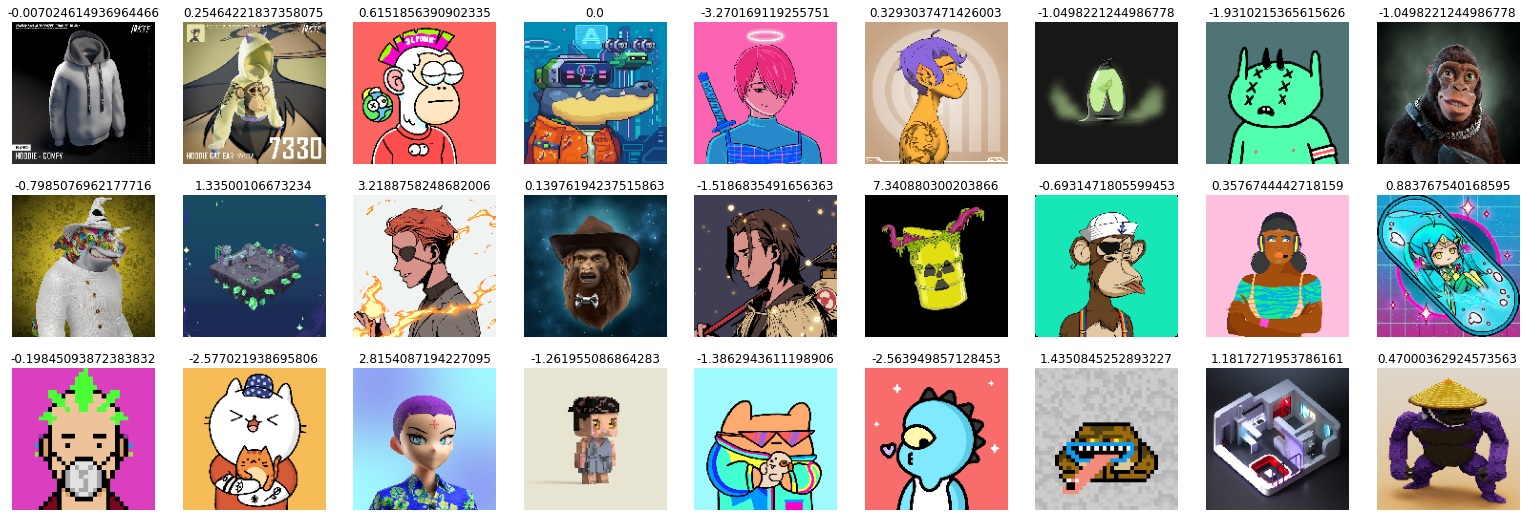

In [9]:
# visualising the images before training
# plotting 1 image from first 27 collections
fig = plt.figure(figsize = (27,9))

count = 1
for i in range(27):
    # img = os.listdir(f'{imagedir}/{collections[i]}')[2]                                           
    ax = fig.add_subplot(3, 9, count)
    fn = image.load_img(data[i][2], target_size = (150,150))
    plt.imshow(fn, cmap='Greys_r')
    plt.title(data[i][1])
    count += 1
    plt.axis('off')
plt.show()

In [9]:
print(f'Size of each feature vector:')
data[0][0].shape

Size of each feature vector:


(100352,)

In [9]:
# save features and price as csv for logging purpose and to avoid retraining of model
data_cleaned = []
for i in range(len(data)):
    data_cleaned.append(np.append(data[i][0], data[i][1]))

np.savetxt(f'{rootdir}/outputs/data_cleaned.csv', data_cleaned, delimiter=",", fmt='%s')

In [7]:
# shuffle and split training and testing data
train_data = []
test_data = []

np.random.shuffle(data) # shuffling data to reduce variance and making sure that model remains general and overfit less
test_ratio = 0.1 # 90% training data 10% testing data
train_data, test_data = np.split(np.array(data,dtype=object), [int(len(data) * (1 - test_ratio))])

print('Size of train data: {}'.format(len(train_data)))
print('Size of test data: {}'.format(len(test_data)))

Size of train data: 1069
Size of test data: 119


### **Data preprocessing for price estimation**

In [8]:
# seperating training data to features and labels
split_train_start = time.time()
X_train = []                                                                   
y_train = []
train_images = []

for features, label, img_path in train_data:
    X_train.append(features)
    y_train.append(label)     
    train_images.append(img_path)

split_train_end = time.time()
print(f'Time taken to split training data: {split_train_end - split_train_start} seconds')

Time taken to split training data: 0.0016815662384033203 seconds


In [9]:
# seperating testing data to features and labels
split_test_start = time.time()
X_test = []
y_test = []
test_images = []

for features, label, img_path in test_data:
    X_test.append(features)
    y_test.append(label)  
    test_images.append(img_path)

split_test_end = time.time()
print(f'Time taken to split testing data: {split_train_end - split_train_start} seconds')

Time taken to split testing data: 0.0016815662384033203 seconds


### **Model training**

#### Model evaluation statistics

In [10]:
# function to return RMSE, MAE and R^2 values
def get_stats(pred, out):
    return pd.DataFrame(
        {
            "RMSE": mean_squared_error(out, pred, squared=False),
            "MAE": mean_absolute_error(out, pred),
            "R^2": r2_score(out, pred),
            # "Adjusted R^2": adj_r2(inp, y_act, y_pred),
        },
        index=[0],
    )

#### Linear Regression

In [14]:
# train Linear Regression model
lr_start = time.time()
X_train = np.array(X_train)
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)
lr_end = time.time()
print(f'Time taken to train linear regression model: {lr_end - lr_start} seconds')
print(f'Score: {lin_reg_model.score(X_train, y_train)}')

Time taken to train linear regression model: 3.6373891830444336 seconds
Score: 0.9975801947204488


#### Linear Regression with Principal Component Analysis

In [11]:
# PCA function
def pca_dec(data, n):
  pca = PCA(n)
  X_dec = pca.fit_transform(data)
  return X_dec, pca

In [21]:
# run PCA iteratively to reduce number of dimensions to see which number gives the best results
for n_dimensions in range(1, min(20, len(test_data))):
    X_train_reduced, pca_train = pca_dec(X_train, n_dimensions)
    X_test_reduced, pca_test = pca_dec(X_test, n_dimensions)

    X_train_reduced = np.array(X_train_reduced)
    lin_reg_model = LinearRegression()
    lin_reg_model.fit(X_train_reduced, y_train)

    res_reduced = lin_reg_model.predict(X_test_reduced)

    print(f"Number of dimensions: {n_dimensions}")
    print("Training Performance:")
    print(get_stats(lin_reg_model.predict(X_train_reduced), y_train))

    # Checking model performance on test set
    print("Test Performance:")
    print(get_stats(res_reduced, y_test))

Number of dimensions: 1
Training Performance:
      RMSE       MAE      R^2
0  2.13391  1.636574  0.00514
Test Performance:
       RMSE     MAE       R^2
0  1.772949  1.2408 -0.384344
Number of dimensions: 2
Training Performance:
       RMSE       MAE       R^2
0  2.122516  1.639619  0.015736
Test Performance:
       RMSE       MAE       R^2
0  1.605478  1.134927 -0.135168
Number of dimensions: 3
Training Performance:
       RMSE       MAE       R^2
0  2.120673  1.648164  0.017444
Test Performance:
       RMSE       MAE       R^2
0  1.667036  1.227058 -0.223888
Number of dimensions: 4
Training Performance:
       RMSE       MAE       R^2
0  2.093038  1.590184  0.042886
Test Performance:
       RMSE       MAE      R^2
0  1.769543  1.414862 -0.37903
Number of dimensions: 5
Training Performance:
       RMSE       MAE       R^2
0  2.093042  1.590295  0.042882
Test Performance:
       RMSE       MAE       R^2
0  1.773036  1.418171 -0.384481
Number of dimensions: 6
Training Performance:
    

In [12]:
# run PCA again with selected number of dimensions (in this case 3)
pca_start = time.time()
# Decomposing the train set:
X_train_reduced, pca_train = pca_dec(X_train, 3)

# Decomposing the test set:
X_test_reduced, pca_test = pca_dec(X_test, 3)

pca_end = time.time()
print(f'Time taken to reduce dimensions: {pca_end - pca_start} seconds')
print(f'Shape of each feature vector now: {X_train_reduced[0].shape}')

Time taken to reduce dimensions: 1.8643062114715576 seconds
Shape of each feature vector now: (3,)


In [24]:
# Train Linear Regression model after PCA
lr_start = time.time()
X_train_reduced = np.array(X_train_reduced)
lin_reg_reduced_model = LinearRegression()
lin_reg_reduced_model.fit(X_train_reduced, y_train)
lr_end = time.time()
print(f'Time taken to train linear regression model after PCA: {lr_end - lr_start} seconds')
print(f'Score: {lin_reg_reduced_model.score(X_train_reduced, y_train)}')

Time taken to train linear regression model after PCA: 0.001107931137084961 seconds
Score: 0.017381556563558775


#### Support Vector Regression

In [15]:
# train Support Vector Regression model
svr_start = time.time()
X_train = np.array(X_train)
svr_model = SVR(kernel='sigmoid')
svr_model.fit(X_train, y_train)
svr_end = time.time()
print(f'Time taken to train support vector regression model: {svr_end - svr_start} seconds')
print(f'Score: {svr_model.score(X_train, y_train)}')

#### Linear Support Vector Regression

In [26]:
# train Linear Support Vector Regression model
lsvr_start = time.time()
X_train = np.array(X_train)
lin_svr_model = make_pipeline(StandardScaler(), LinearSVR(random_state=0, tol=1e-5))
lin_svr_model.fit(X_train, y_train)
lsvr_end = time.time()
print(f'Time taken to train linear support vector regression model: {lsvr_end - lsvr_start} seconds')
print(f'Score: {lin_svr_model.score(X_train, y_train)}')

Time taken to train linear support vector regression model: 20.866076707839966 seconds
Score: 0.9997674574301446


#### Stochastic Gradient Descent Regression

In [27]:
# train Stochastic Gradient Descent Regression model
sgdr_start = time.time()
X_train = np.array(X_train)
sgd_reg_model = make_pipeline(StandardScaler(), SGDRegressor(max_iter=10000, tol=1e-3))
sgd_reg_model.fit(X_train, y_train)
sgdr_end = time.time()
print(f'Time taken to train stochastic gradient descent regression model: {sgdr_end - sgdr_start} seconds')
print(f'Score: {sgd_reg_model.score(X_train, y_train)}')

Time taken to train stochastic gradient descent regression model: 0.5138158798217773 seconds
Score: -6.0945493375421575e+26


#### Generalized Liner Model (Poisson)

In [21]:
# train GLM model with poisson
poi_start = time.time()
poi_model = sm.GLM(y_train,sm.add_constant(X_train_reduced),family=sm.families.Poisson()).fit(method ="lbfgs")
poi_end = time.time()
print(f'Time taken to train GLM(poisson) model: {poi_end - poi_start} seconds')

Time taken to train GLM(poisson) model: 0.010071516036987305 seconds


#### Generalized Linear Model (Gaussian)

In [23]:
# train GLM model with gaussian
gau_start = time.time()
gau_model = sm.GLM(y_train,sm.add_constant(X_train_reduced),family=sm.families.Gaussian(sm.families.links.log)).fit(method="lbfgs")
gau_end = time.time()
print(f'Time taken to train GLM(gaussian) model: {gau_end - gau_start} seconds')

Time taken to train GLM(gaussian) model: 0.005393266677856445 seconds


### **Model testing and evaluation**

#### Linear Regression

In [29]:
test_start = time.time()
# Checking model performance on train data
print("Training Performance:")
print(get_stats(lin_reg_model.predict(X_train), y_train))
# Checking model performance on test data
print("Test Performance:")
print(get_stats(lin_reg_model.predict(X_test), y_test))
test_end = time.time()
print(f'Time taken to test linear regression model: {test_end - test_start} seconds')

Training Performance:
       RMSE       MAE       R^2
0  0.090801  0.035937  0.997846
Test Performance:
          RMSE          MAE            R^2
0  1889.690826  1272.244792 -962716.864207
Time taken to test linear regression model: 0.2730262279510498 seconds


#### Linear Regression with Pricipal Component Analysis

In [29]:
test_start = time.time()
# Checking model performance on train data
print("Training Performance:")
print(get_stats(lin_reg_reduced_model.predict(X_train_reduced), y_train))
# Checking model performance on test data
print("Test Performance:")
print(get_stats(lin_reg_reduced_model.predict(X_test_reduced), y_test))
test_end = time.time()
print(f'Time taken to test linear regression model after PCA: {test_end - test_start} seconds')

Training Performance:
       RMSE       MAE       R^2
0  2.120741  1.647985  0.017382
Test Performance:
      RMSE       MAE       R^2
0  1.66601  1.225158 -0.222381
Time taken to test linear regression model after PCA: 0.005803346633911133 seconds


#### Support Vector Regression

In [30]:
test_start = time.time()
# Checking model performance on train data
print("Training Performance:")
print(get_stats(svr_model.predict(X_train), y_train))
# Checking model performance on test data
print("Test Performance:")
print(get_stats(svr_model.predict(X_test), y_test))
test_end = time.time()
print(f'Time taken to test support vector regression model: {test_end - test_start} seconds')

Training Performance:
       RMSE       MAE       R^2
0  1.472506  0.845542  0.433542
Test Performance:
       RMSE    MAE       R^2
0  1.531928  0.997  0.367305
Time taken to test support vector regression model: 43.15921902656555 seconds


#### Linear Support Vector Regresssion

In [32]:
test_start = time.time()
# Checking model performance on train data
print("Training Performance:")
print(get_stats(lin_svr_model.predict(X_train), y_train))
# Checking model performance on test data
print("Test Performance:")
print(get_stats(lin_svr_model.predict(X_test), y_test))
test_end = time.time()
print(f'Time taken to test linear support vector regression model: {test_end - test_start} seconds')

Training Performance:
       RMSE       MAE       R^2
0  0.032625  0.028032  0.999767
Test Performance:
       RMSE    MAE       R^2
0  2.043787  1.729 -0.839599
Time taken to test linear support vector regression model after PCA: 0.10974788665771484 seconds


#### Stochastic Gradient Descent Regression

In [33]:
test_start = time.time()
# Checking model performance on train data
print("Training Performance:")
print(get_stats(sgd_reg_model.predict(X_train), y_train))
# Checking model performance on test data
print("Test Performance:")
print(get_stats(sgd_reg_model.predict(X_test), y_test))
test_end = time.time()
print(f'Time taken to test stochastic gradient descent regression model: {test_end - test_start} seconds')

Training Performance:
           RMSE           MAE           R^2
0  5.281606e+13  3.377083e+13 -6.094549e+26
Test Performance:
           RMSE           MAE           R^2
0  4.470314e+13  2.676144e+13 -8.800914e+26
Time taken to test stochastic gradient descent regression model: 0.0811610221862793 seconds


#### Generalized Linear Model (Poisson)

In [22]:
test_start = time.time()
# Checking model performance on train data
print("Training Performance:")
print(get_stats(poi_model.predict(sm.add_constant(X_train_reduced)), y_train))
# Checking model performance on test data
print("Test Performance:")
print(get_stats(poi_model.predict(sm.add_constant(X_test_reduced)), y_test))
test_end = time.time()
print(f'Time taken to test GLM (poisson) model: {test_end - test_start} seconds')

Training Performance:
       RMSE       MAE       R^2
0  2.327792  1.912253 -0.476225
Test Performance:
       RMSE       MAE       R^2
0  2.667158  2.122248 -0.384407
Time taken to test GLM (poisson) model: 0.006406545639038086 seconds


#### Generalized Linear Model (Gaussian)

In [24]:
test_start = time.time()
# Checking model performance on train data
print("Training Performance:")
print(get_stats(gau_model.predict(sm.add_constant(X_train_reduced)), y_train))
# Checking model performance on test data
print("Test Performance:")
print(get_stats(gau_model.predict(sm.add_constant(X_test_reduced)), y_test))
test_end = time.time()
print(f'Time taken to test GLM (gaussian) model: {test_end - test_start} seconds')

Training Performance:
       RMSE       MAE       R^2
0  2.400059  1.987101 -0.569307
Test Performance:
       RMSE       MAE       R^2
0  2.785259  2.211555 -0.509724
Time taken to test GLM (gaussian) model: 0.0065534114837646484 seconds


### **Export trained model**

In [40]:
# save the model to disk
filename = 'nft_estimator_model_LR.sav'
filepath = f'{rootdir}/outputs/{filename}'
pickle.dump(lin_reg_model, open(filepath, 'wb'))

In [49]:
# save the model to disk
filename = 'nft_estimator_model__LR_reduced.sav'
filepath = f'{rootdir}/outputs/{filename}'
pickle.dump(lin_reg_reduced_model, open(filepath, 'wb'))

In [16]:
# save the model to disk
filename = 'nft_estimator_model_SVR.sav'
filepath = f'{rootdir}/outputs/{filename}'
pickle.dump(svr_model, open(filepath, 'wb'))

In [28]:
# save the model to disk
filename = 'nft_estimator_model_LSVR.sav'
filepath = f'{rootdir}/outputs/{filename}'
pickle.dump(lin_svr_model, open(filepath, 'wb'))

In [29]:
# save the model to disk
filename = 'nft_estimator_model_SGDR.sav'
filepath = f'{rootdir}/outputs/{filename}'
pickle.dump(sgd_reg_model, open(filepath, 'wb'))

### **Test loaded model**

In [23]:
# load the model from disk
loaded_model = pickle.load(open(filepath, 'rb'))
res = loaded_model.score(X_test, y_test)
print(res)

-0.014063821538782495


In [55]:
prediction = loaded_model.predict(X_test)
for i, img_path in enumerate(test_images):
  image_name = os.path.basename(img_path) 
  print(image_name, prediction[i])                                                                   

10ktf-stockroom-#65539.png 0.9851438
10ktf-#562992903096070.png 0.5525571
10ktf-#281517926384586.png 0.7701943
10ktf-stockroom-#5.png 2.4281087
10ktf-stockroom-#65540.png 1.1306131
10ktf-#844433520067370.png 1.2056255
3landers-#9992.png 1.4237486
10ktf-#281492156583100.png 0.61382663
10ktf-stockroom-#2.png 1.0006132
10ktf-stockroom-#4.png 2.5562818
10ktf-#562967133300018.png 0.8825573
10ktf-#1407430718132512.png 0.81653965
10ktf-#562975723225469.png 0.49850345
10ktf-#1125917086715068.png 1.2235523
10ktf-#562992903101374.png 0.16868293
10ktf-#1125908496785555.png 0.94214094
10ktf-#1125947151485001.png 0.8151973
10ktf-#562975723225342.png 0.54846144
10ktf-#562967133299945.png 0.5983885
10ktf-#562954248389175.png 0.8505796
10ktf-#1407392063423568.png 0.78739786
10ktf-#562958543361063.png 0.93680507
10ktf-#1407383473493062.png 0.654476
10ktf-#562997198062120.png 0.45779598
10ktf-stockroom-#65537.png 0.9832802
